# PINN for microfluidics experiments

This is a notebook in which we train PINNs to test hypotheses about models for the microfluidic particles experiments and also learn parameters for those equations

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt

lw = 1
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['font.size'] = 8
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'upper'

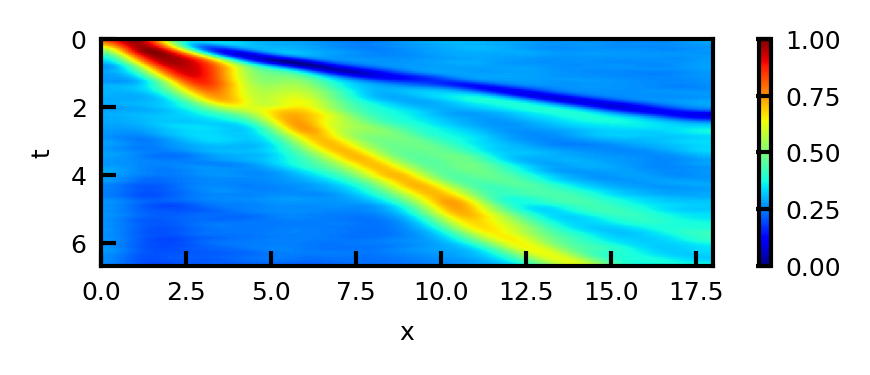

In [2]:
U_star = np.load('data/rescaled_1d.npy', mmap_mode='r')


T, N = U_star.shape
tmin, xmin = 0, 0

dx = 18 / N
dt = 4 / 60

U_star = U_star[:100, :]

T, N = U_star.shape
xmax = N * dx
tmax = T * dt

X_star = np.linspace(0, xmax, N)
t_star = np.linspace(0, tmax, T)

# Rearrange Data 
XX = np.tile(X_star[:,None], (1,T)).T   # T x N
TT = np.tile(t_star[:,None], (1,N))     # T x N

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

def plot(ax, u):
    ax.clear()
    im = ax.imshow(u[:, ::-1],  cmap='jet', extent=[0, xmax, tmax, 0], vmin=0, vmax=1)
    ax.set(xlabel='x', ylabel='t')
    plt.colorbar(im, ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(4,1), dpi=300)
plot(ax, U_star)


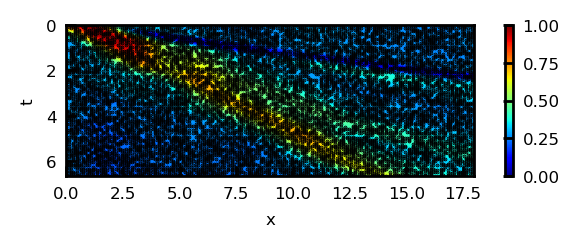

In [4]:
#Select points for bulk physics loss
N_u = 10000
idx = np.random.choice(N*T, N_u, replace=False)
x_u = x[idx,:]
t_u = t[idx,:]
u_u = u[idx, :]

ax = plt.figure(figsize=(4, 1), dpi=200).gca()
plot(ax, U_star)
ax.scatter(x_u, t_u, color='black', s=.1)

# Burgers' equation

$$ u_t + (c - a u) u_x = D u_{xx} $$

  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.261428e-02, MSE: 1.065248e-02, Phys: 1.961804e-04, 
	u_t + -1.975 u_x + -0.058 u u_x - 2.066 u_xx = 0
Loss: 6.136400e-03, MSE: 5.309367e-03, Phys: 8.270337e-05, 
	u_t + -1.982 u_x + -0.035 u u_x - 0.255 u_xx = 0
Loss: 4.138540e-03, MSE: 3.791217e-03, Phys: 3.473228e-05, 
	u_t + -1.954 u_x + 0.016 u u_x - 0.108 u_xx = 0
Loss: 3.771968e-03, MSE: 3.446216e-03, Phys: 3.257516e-05, 
	u_t + -2.025 u_x + 0.146 u u_x - 0.079 u_xx = 0
Loss: 3.626754e-03, MSE: 3.364638e-03, Phys: 2.621161e-05, 
	u_t + -2.118 u_x + 0.324 u u_x - 0.096 u_xx = 0
Loss: 3.530859e-03, MSE: 3.264796e-03, Phys: 2.660633e-05, 
	u_t + -2.261 u_x + 0.592 u u_x - 0.140 u_xx = 0
Loss: 3.464308e-03, MSE: 3.215732e-03, Phys: 2.485757e-05, 
	u_t + -2.320 u_x + 0.685 u u_x - 0.158 u_xx = 0
Loss: 3.388967e-03, MSE: 3.165856e-03, Phys: 2.231109e-05, 
	u_t + -2.376 u_x + 0.807 u u_x - 0.175 u_xx = 0
Loss: 3.352757e-03, MSE: 3.118502e-03, Phys: 2.342552e-05, 
	u_t + -2.446 u_x + 0.944 u u_x - 0.200 u_xx = 0
Loss: 3.322894e-0

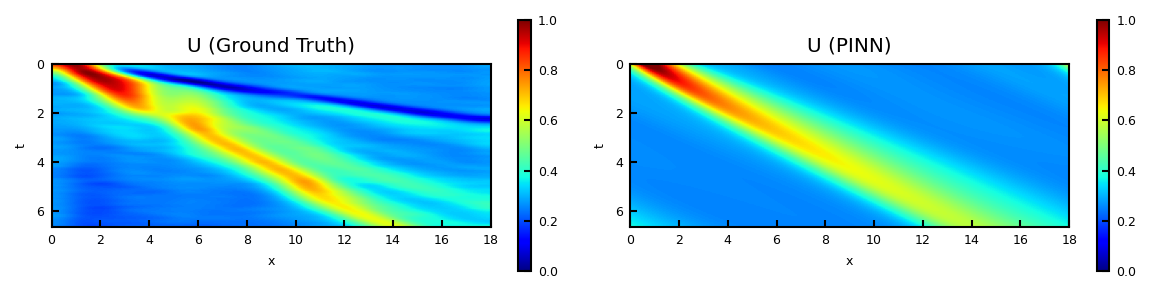

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class BurgersPINN(nn.Module):
    def __init__(self,
                 x_u, 
                 t_u, 
                 u_u,
                 Nb=100):
        super().__init__()
        act = Sin
        layers = [2, 50, 50, 50, 50, 50, 1]
        lst = []
        for i in range(len(layers)-2):
            lst.append(nn.Linear(layers[i], layers[i+1]))
            lst.append(act())
        lst.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*lst)
        
        self.x_u = nn.Parameter(x_u[:, None], requires_grad=True)
        self.t_u = nn.Parameter(t_u[:, None], requires_grad=True)
        self.u_u = nn.Parameter(u_u[:, None], requires_grad=True)
        
        X = torch.cat([t_u, x_u], dim=-1)
        self.lb = nn.Parameter(X.min(0)[0], requires_grad=False)
        self.ub = nn.Parameter(X.max(0)[0], requires_grad=False)
        
        #Build boundary points
        t_b = torch.linspace(self.lb[0], self.ub[0], Nb)[:, None]
        x_b = torch.ones_like(t_b)
        self.t_b = nn.Parameter(t_b, requires_grad=True)
        self.x_b0 = nn.Parameter(x_b * self.lb[1], requires_grad=True)
        self.x_b1 = nn.Parameter(x_b * self.ub[1], requires_grad=True)
        
        self.params = nn.Parameter(torch.ones(3, dtype=torch.float), requires_grad=True)
        self.model.register_parameter('params', self.params)
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e1, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-9, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)
        
        self.iter = 0
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)
        
    def forward(self, X):
        H = 2. * (X - self.lb) / (self.ub - self.lb) - 1.0
        return self.model(H)

    def print(self, loss=None, mse=None, phys=None):
        outstr = ''
        if loss is not None:
            outstr += 'Loss: %e, MSE: %e, Phys: %e, ' % \
                (
                    loss.item() if loss else 0., 
                    mse.item() if loss else 0., 
                    phys.item() if loss else 0.,
                )
        outstr += '\n\tu_t + %.3f u_x + %.3f u u_x - %.3f u_xx = 0' % \
            (
                self.params[0].detach().item(),
                self.params[1].detach().item(),
                self.params[2].exp().detach().item(),
            )
        print(outstr)
        
    def loss_func(self):
        mse, phys = self.training_step()
        loss = mse + 1e1 * phys
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 1000 == 0:
            self.print(loss, mse, phys)
        
        return loss
    
    def train(self, lbfgsIter):
        for epoch in tqdm(range(lbfgsIter)):
            self.optimizer.step(self.loss_func)
            self.scheduler.step()
        
        self.print()
    
    def training_step(self):
        u_u = self(torch.cat([self.t_u, self.x_u], dim=-1))
        x = self.x_u
        t = self.t_u
        
        u_t = torch.autograd.grad(u_u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u_u.sum(), x, retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        
        A = self.params[0]
        B = self.params[1]
        D = torch.exp(self.params[2])
        f_u = u_t + A * u_x + B * u_u * u_x - D * u_xx
        
        u_b0 = self(torch.cat([self.t_b, self.x_b0], dim=-1))
        u_b1 = self(torch.cat([self.t_b, self.x_b1], dim=-1))
        u_b0x = torch.autograd.grad(u_b0.sum(), self.x_b0, create_graph=True)[0]
        u_b1x = torch.autograd.grad(u_b1.sum(), self.x_b1, create_graph=True)[0]
        
        bound = (u_b0 - u_b1).pow(2).mean() + (u_b0x - u_b1x).pow(2).mean()
        
        mse = (u_u - self.u_u).pow(2).mean()
        phys = f_u.pow(2).mean()
        
        return mse, phys+bound
    
def model_summary():
    preds = model(torch.from_numpy(np.stack([t, x], axis=-1)).float().to(device)).detach().cpu().numpy()
    u1 = preds.reshape(U_star.shape)

    fig, ax = plt.subplots(1, 2, figsize=(8, 2), dpi=150)
    plot(ax[0], U_star)
    plot(ax[1], u1)
    
    ax[0].set_title('U (Ground Truth)')
    ax[1].set_title('U (PINN)')
    plt.tight_layout()
    

device = torch.device('cuda:0')
model = BurgersPINN(
    torch.from_numpy(x_u).float(),
    torch.from_numpy(t_u).float(),
    torch.from_numpy(u_u).float(),
)
model.to(device)
model.train(3)
model_summary()

# KdV-Burgers' equation

$$ u_t + (c - a u) u_x = D u_{xx}  + \beta u_{xxx} $$

  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.081187e-02, MSE: 1.006739e-02, Phys: 7.444761e-05, 
	u_t + -1.873 u_x + -0.026 u u_x - 0.945 u_xx + 1.221 u_xxx = 0
Loss: 9.549797e-03, MSE: 5.953677e-03, Phys: 3.596120e-04, 
	u_t + -2.081 u_x + 0.337 u u_x - 0.213 u_xx + 0.204 u_xxx = 0
Loss: 4.143531e-03, MSE: 3.670216e-03, Phys: 4.733151e-05, 
	u_t + -2.172 u_x + 0.443 u u_x - 0.108 u_xx + 0.026 u_xxx = 0
Loss: 3.743036e-03, MSE: 3.431086e-03, Phys: 3.119494e-05, 
	u_t + -2.179 u_x + 0.456 u u_x - 0.091 u_xx + 0.016 u_xxx = 0
Loss: 3.547805e-03, MSE: 3.299591e-03, Phys: 2.482140e-05, 
	u_t + -2.180 u_x + 0.457 u u_x - 0.097 u_xx + 0.012 u_xxx = 0
Loss: 3.465774e-03, MSE: 3.174809e-03, Phys: 2.909654e-05, 
	u_t + -2.262 u_x + 0.600 u u_x - 0.135 u_xx + 0.009 u_xxx = 0
Loss: 3.370785e-03, MSE: 3.140207e-03, Phys: 2.305779e-05, 
	u_t + -2.348 u_x + 0.795 u u_x - 0.181 u_xx + 0.025 u_xxx = 0
Loss: 3.335066e-03, MSE: 3.070328e-03, Phys: 2.647379e-05, 
	u_t + -2.473 u_x + 1.057 u u_x - 0.195 u_xx + 0.034 u_xxx = 0
Loss: 3.253561e

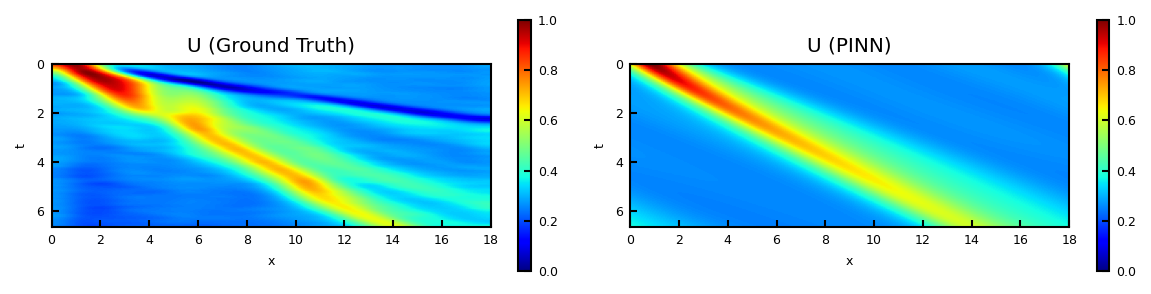

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class KdVBurgers_PINN(nn.Module):
    def __init__(self,
                 x_u, 
                 t_u, 
                 u_u,
                 Nb=100):
        super().__init__()
        act = Sin
        layers = [2, 50, 50, 50, 50, 50, 1]
        lst = []
        for i in range(len(layers)-2):
            lst.append(nn.Linear(layers[i], layers[i+1]))
            lst.append(act())
        lst.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*lst)
        
        self.x_u = nn.Parameter(x_u[:, None], requires_grad=True)
        self.t_u = nn.Parameter(t_u[:, None], requires_grad=True)
        self.u_u = nn.Parameter(u_u[:, None], requires_grad=True)
        
        X = torch.cat([t_u, x_u], dim=-1)
        self.lb = nn.Parameter(X.min(0)[0], requires_grad=False)
        self.ub = nn.Parameter(X.max(0)[0], requires_grad=False)
        
        #Build boundary points
        t_b = torch.linspace(self.lb[0], self.ub[0], Nb)[:, None]
        x_b = torch.ones_like(t_b)
        self.t_b = nn.Parameter(t_b, requires_grad=True)
        self.x_b0 = nn.Parameter(x_b * self.lb[1], requires_grad=True)
        self.x_b1 = nn.Parameter(x_b * self.ub[1], requires_grad=True)
        
        self.params = nn.Parameter(torch.ones(4, dtype=torch.float), requires_grad=True)
        self.model.register_parameter('params', self.params)
        
        self.optimizer_Adam = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e1, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-9, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)
        
        self.iter = 0
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)
        
    def forward(self, X):
        H = 2. * (X - self.lb) / (self.ub - self.lb) - 1.0
        return self.model(H)

    def print(self, loss=None, mse=None, phys=None):
        outstr = ''
        if loss is not None:
            outstr += 'Loss: %e, MSE: %e, Phys: %e, ' % \
                (
                    loss.item() if loss else 0., 
                    mse.item() if loss else 0., 
                    phys.item() if loss else 0.,
                )
        outstr += '\n\tu_t + %.3f u_x + %.3f u u_x - %.3f u_xx + %.3f u_xxx = 0' % \
            (
                self.params[0].detach().item(),
                self.params[1].detach().item(),
                self.params[2].exp().detach().item(),
                self.params[3].detach().item(),
            )
        print(outstr)
        
    def loss_func(self):
        mse, phys = self.training_step()
        loss = mse + 1e1 * phys
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 1000 == 0:
            self.print(loss, mse, phys)
        
        return loss
    
    def train(self, lbfgsIter):
        for epoch in tqdm(range(lbfgsIter)):
            self.optimizer.step(self.loss_func)
            self.scheduler.step()
        
        self.print()
    
    def training_step(self):
        u_u = self(torch.cat([self.t_u, self.x_u], dim=-1))
        x = self.x_u
        t = self.t_u
        
        u_t = torch.autograd.grad(u_u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u_u.sum(), x, retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, retain_graph=True, create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx.sum(), x, create_graph=True)[0]
        
        A = self.params[0]
        B = self.params[1]
        D = torch.exp(self.params[2])
        C = self.params[3]
        f_u = u_t + A * u_x + B * u_u * u_x - D * u_xx + C * u_xxx
        
        u_b0 = self(torch.cat([self.t_b, self.x_b0], dim=-1))
        u_b1 = self(torch.cat([self.t_b, self.x_b1], dim=-1))
        u_b0x = torch.autograd.grad(u_b0.sum(), self.x_b0, create_graph=True)[0]
        u_b1x = torch.autograd.grad(u_b1.sum(), self.x_b1, create_graph=True)[0]
        
        bound = (u_b0 - u_b1).pow(2).mean() + (u_b0x - u_b1x).pow(2).mean()
        
        mse = (u_u - self.u_u).pow(2).mean()
        phys = f_u.pow(2).mean()
        
        return mse, phys+bound
    

device = torch.device('cuda:0')
model = KdVBurgers_PINN(
    torch.from_numpy(x_u).float(),
    torch.from_numpy(t_u).float(),
    torch.from_numpy(u_u).float(),
)
model.to(device)
model.train(3)
model_summary()

# KdV Equation 

$$ u_t + (c - a u) u_x = \beta u_{xxx} $$

  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.370438e-01, MSE: 2.351748e-02, Phys: 1.135263e-02, 
	u_t + -1.663 u_x + 0.137 u u_x + 1.140 u_xxx = 0
Loss: 6.646668e-03, MSE: 5.347475e-03, Phys: 1.299192e-04, 
	u_t + -2.185 u_x + 0.451 u u_x + -0.044 u_xxx = 0
Loss: 4.380869e-03, MSE: 3.941794e-03, Phys: 4.390752e-05, 
	u_t + -2.180 u_x + 0.409 u u_x + -0.011 u_xxx = 0
Loss: 3.911970e-03, MSE: 3.633752e-03, Phys: 2.782188e-05, 
	u_t + -2.142 u_x + 0.368 u u_x + 0.010 u_xxx = 0
Loss: 3.830526e-03, MSE: 3.541033e-03, Phys: 2.894926e-05, 
	u_t + -2.140 u_x + 0.357 u u_x + 0.009 u_xxx = 0
Loss: 3.798513e-03, MSE: 3.498368e-03, Phys: 3.001449e-05, 
	u_t + -2.136 u_x + 0.356 u u_x + 0.010 u_xxx = 0
Loss: 3.780391e-03, MSE: 3.489772e-03, Phys: 2.906191e-05, 
	u_t + -2.136 u_x + 0.361 u u_x + 0.010 u_xxx = 0

	u_t + -2.136 u_x + 0.361 u u_x + 0.010 u_xxx = 0


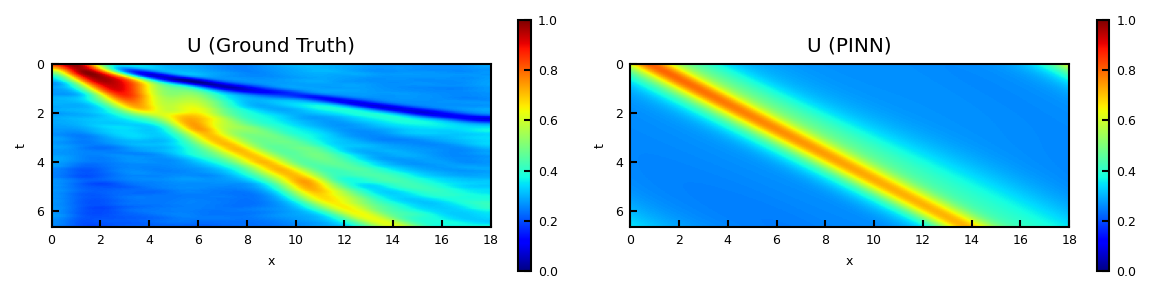

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class KdVPINN(nn.Module):
    def __init__(self,
                 x_u, 
                 t_u, 
                 u_u,
                 Nb=100):
        super().__init__()
        act = Sin
        layers = [2, 50, 50, 50, 50, 50, 1]
        lst = []
        for i in range(len(layers)-2):
            lst.append(nn.Linear(layers[i], layers[i+1]))
            lst.append(act())
        lst.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*lst)
        
        self.x_u = nn.Parameter(x_u[:, None], requires_grad=True)
        self.t_u = nn.Parameter(t_u[:, None], requires_grad=True)
        self.u_u = nn.Parameter(u_u[:, None], requires_grad=True)
        
        X = torch.cat([t_u, x_u], dim=-1)
        self.lb = nn.Parameter(X.min(0)[0], requires_grad=False)
        self.ub = nn.Parameter(X.max(0)[0], requires_grad=False)
        
        #Build boundary points
        t_b = torch.linspace(self.lb[0], self.ub[0], Nb)[:, None]
        x_b = torch.ones_like(t_b)
        self.t_b = nn.Parameter(t_b, requires_grad=True)
        self.x_b0 = nn.Parameter(x_b * self.lb[1], requires_grad=True)
        self.x_b1 = nn.Parameter(x_b * self.ub[1], requires_grad=True)
        
        self.params = nn.Parameter(torch.ones(3, dtype=torch.float), requires_grad=True)
        self.model.register_parameter('params', self.params)
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e1, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-9, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)
        
        self.iter = 0
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)
        
    def forward(self, X):
        H = 2. * (X - self.lb) / (self.ub - self.lb) - 1.0
        return self.model(H)

    def print(self, loss=None, mse=None, phys=None):
        outstr = ''
        if loss is not None:
            outstr += 'Loss: %e, MSE: %e, Phys: %e, ' % \
                (
                    loss.item() if loss else 0., 
                    mse.item() if loss else 0., 
                    phys.item() if loss else 0.,
                )
        outstr += '\n\tu_t + %.3f u_x + %.3f u u_x + %.3f u_xxx = 0' % \
            (
                self.params[0].detach().item(),
                self.params[1].detach().item(),
                self.params[2].detach().item(),
            )
        print(outstr)
        
    def loss_func(self):
        mse, phys = self.training_step()
        loss = mse + 1e1 * phys
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 1000 == 0:
            self.print(loss, mse, phys)
        
        return loss
    
    def train(self, lbfgsIter):
        for epoch in tqdm(range(lbfgsIter)):
            self.optimizer.step(self.loss_func)
            self.scheduler.step()
        
        self.print()
    
    def training_step(self):
        u_u = self(torch.cat([self.t_u, self.x_u], dim=-1))
        x = self.x_u
        t = self.t_u
        
        u_t = torch.autograd.grad(u_u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u_u.sum(), x, retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, retain_graph=True, create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx.sum(), x, retain_graph=True, create_graph=True)[0]

        
        A = self.params[0]
        B = self.params[1]
        C = self.params[2]
        f_u = u_t + A * u_x + B * u_u * u_x + C * u_xxx
        
        u_b0 = self(torch.cat([self.t_b, self.x_b0], dim=-1))
        u_b1 = self(torch.cat([self.t_b, self.x_b1], dim=-1))
        u_b0x = torch.autograd.grad(u_b0.sum(), self.x_b0, create_graph=True)[0]
        u_b1x = torch.autograd.grad(u_b1.sum(), self.x_b1, create_graph=True)[0]
        
        bound = (u_b0 - u_b1).pow(2).mean() + (u_b0x - u_b1x).pow(2).mean()
        
        mse = (u_u - self.u_u).pow(2).mean()
        phys = f_u.pow(2).mean()
        
        return mse, phys+bound
    
def model_summary():
    preds = model(torch.from_numpy(np.stack([t, x], axis=-1)).float().to(device)).detach().cpu().numpy()
    u1 = preds.reshape(U_star.shape)

    fig, ax = plt.subplots(1, 2, figsize=(8, 2), dpi=150)
    plot(ax[0], U_star)
    plot(ax[1], u1)
    
    ax[0].set_title('U (Ground Truth)')
    ax[1].set_title('U (PINN)')
    plt.tight_layout()
    

device = torch.device('cuda:0')
model = KdVPINN(
    torch.from_numpy(x_u).float(),
    torch.from_numpy(t_u).float(),
    torch.from_numpy(u_u).float(),
)
model.to(device)
model.train(3)
model_summary()